### Cell 0: ( Only for Colab ) Install the git **repository**

In [1]:
import sys
import os

# 1. Clone the repository
!git clone -b planning https://github.com/orc-podavini-grisenti/final_assignment

# 2. Point the project_root specifically to the cloned folder
# In Colab, the folder structure will be /content/final_assignment/
project_root = os.path.abspath('/content/final_assignment')

# 3. Add that specific folder to the system path
if project_root not in sys.path:
    sys.path.append(project_root)


# 4. Link the Drive to the colab in order to store the results
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/final_assignment/outputs/models_saved"

# Crea la cartella se non esiste
if not os.path.exists(drive_path):
    os.makedirs(drive_path)

fatal: destination path 'final_assignment' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Cell 1: Imports & Setup

In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

# --- PATH SETUP ---
# Add the project root to sys.path so we can import envs/planner
# Adjust '..' depending on where this notebook is located relative to root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from envs.unicycle_env import UnicycleEnv
from models.navigation_network import NavAgent
from utils.normalization import ObservationNormalizer

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


### Cell 2: Load Training Hyperparameters

In [4]:
# --- REWARD WEIGHTS (Tweakable) ---
W_GOAL_PROGRESS = 500.0   # Scale for progress reward
W_ALIGNMENT = 5.0
W_SMOOTHNESS = 0.8
W_OBSTACLE_DIST = 0.1
W_DISTANCE_PENALTY = 0.1

REWARD_GOAL = 1000.0      # Success bonus
REWARD_COLLISION = -500.0 # Failure penalty
REWARD_MAX_STEPS = -100.0 # Time-out penalty

# --- PPO SETTINGS ---
MAX_EPISODES = 2000
MAX_STEPS = 250
BATCH_SIZE = 20           # Episodes per update batch
PPO_EPOCHS = 10          # Optimization steps per batch
GAMMA = 0.99             # Discount factor
GAE_LAMBDA = 0.95        # Advantage smoothing
CLIP_EPSILON = 0.2       # PPO clipping range
LR_ACTOR = 3e-4
LR_CRITIC = 1e-3
ENTROPY_COEF = 0.001      # Bonus for maintaining exploration

### Cell 3: Intialization

In [5]:
# 1. Create the weights dictionary from Cell 2 constants
reward_cfg = {
    'W_GOAL_PROGRESS': W_GOAL_PROGRESS,
    'W_ALIGNMENT': W_ALIGNMENT,
    'W_SMOOTHNESS': W_SMOOTHNESS,
    'W_OBSTACLE_DIST': W_OBSTACLE_DIST
}

# 2. Pass this to the environment
# You'll need to update UnicycleEnv.__init__ to accept and pass this to NavigationReward
env = UnicycleEnv(reward_weights=reward_cfg)

# 3. Extract Dimensions
# obs_dim = 3 (rho, alpha, d_theta) + n_rays
n_rays = env.rob_cfg.get('lidar_rays', 20)
obs_dim = 3 + n_rays
action_dim = 2

# 4. Initialize Agent, Normalizer, and Optimizers
agent = NavAgent(obs_dim, action_dim, hidden_dim=512, device=device)
obs_normalizer = ObservationNormalizer(max_dist=5.0, lidar_range=env.rob_cfg['lidar_range'])

optimizer = optim.Adam([
    {'params': agent.actor_head.parameters(), 'lr': LR_ACTOR},
    {'params': agent.critic_head.parameters(), 'lr': LR_CRITIC}
])

reward_history = []

### Cell 4: Helpers

In [6]:
def update_ppo(agent, optimizer, buffer):
    # --- 1. PREPARE DATA ---
    # Flatten everything into single-dimension tensors
    s_batch = torch.FloatTensor(np.array(buffer.states)).to(device)     # [Total_Steps, Obs_Dim]
    a_batch = torch.FloatTensor(np.array(buffer.actions)).to(device)    # [Total_Steps, Action_Dim]
    lp_old = torch.stack(buffer.log_probs).detach().view(-1).to(device) # Flatten to [Total_Steps]
    v_old = torch.stack(buffer.values).detach().view(-1).to(device)     # Flatten to [Total_Steps]

    rewards = buffer.rewards
    masks = [1.0 - float(t) for t in buffer.is_terminals]

    # --- 2. COMPUTE GAE (Equation 11 & 12) ---
    advantages = []
    gae = 0
    for t in reversed(range(len(rewards))):
        # delta_t = r_t + gamma * V(s_t+1) - V(s_t)
        next_value = v_old[t+1] if t + 1 < len(rewards) else 0
        delta = rewards[t] + GAMMA * next_value * masks[t] - v_old[t]

        # A_t = delta_t + (gamma * lambda) * A_t+1
        gae = delta + GAMMA * GAE_LAMBDA * masks[t] * gae
        advantages.insert(0, gae)

    adv_t = torch.FloatTensor(advantages).to(device)
    returns_t = adv_t + v_old # Target values for the critic [cite: 121, 129]

    # Standardize advantages [cite: 29]
    adv_t = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

    # --- 3. OPTIMIZATION EPOCHS ---
    dataset_size = s_batch.size(0) # This should be 5000 (20 episodes * 250 steps)

    # Paper uses small minibatches (e.g., 64) over multiple epochs [cite: 140, 325]
    OPTIM_BATCH_SIZE = 64

    for _ in range(PPO_EPOCHS):
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)

        for start in range(0, dataset_size, OPTIM_BATCH_SIZE):
            idx = indices[start:start + OPTIM_BATCH_SIZE]

            # Extract minibatch
            s_mb, a_mb, lp_mb_old, ret_mb, adv_mb = s_batch[idx], a_batch[idx], lp_old[idx], returns_t[idx], adv_t[idx]

            # lp_new: [MB_Size], v_new: [MB_Size], entropy: [MB_Size]
            lp_new, v_new, entropy = agent.evaluate_actions(s_mb, a_mb)

            # --- 4. CLIPPED OBJECTIVE (Equation 7) ---
            ratio = torch.exp(lp_new - lp_mb_old)
            surr1 = ratio * adv_mb
            surr2 = torch.clamp(ratio, 1 - CLIP_EPSILON, 1 + CLIP_EPSILON) * adv_mb
            loss_actor = -torch.min(surr1, surr2).mean() # [cite: 66, 70]

            # --- 5. VALUE LOSS (Equation 9) ---
            # Both v_new and ret_mb must be [MB_Size] to avoid the broadcasting error
            loss_critic = 0.5 * nn.MSELoss()(v_new, ret_mb) # [cite: 129]
            loss_entropy = -ENTROPY_COEF * entropy.mean() # [cite: 125, 127]

            loss = loss_actor + loss_critic + loss_entropy # [cite: 127]

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
            optimizer.step()

    buffer.clear()



def plot_trajectory(trajectory, goal, episode_num):
    """Visualizes the path of the last episode in a batch."""
    trajectory = np.array(trajectory)
    plt.figure(figsize=(5, 5))
    plt.plot(trajectory[:, 0], trajectory[:, 1], '-b', label="Path")
    plt.plot(trajectory[0, 0], trajectory[0, 1], 'go', label="Start")
    plt.plot(goal[0], goal[1], 'rx', markersize=10, label="Goal")
    # Arrow for target orientation
    plt.arrow(goal[0], goal[1], 0.2*np.cos(goal[2]), 0.2*np.sin(goal[2]),
              head_width=0.05, head_length=0.1, fc='red', ec='red')
    plt.title(f"Batch {episode_num // BATCH_SIZE} Sample Trajectory")
    plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

### Cell 5: Reinforce Update

In [7]:
class PPOBuffer:
    def __init__(self):
        self.states, self.actions, self.log_probs = [], [], []
        self.rewards, self.values, self.is_terminals = [], [], []

    def store(self, s, a, lp, r, v, terminal):
        self.states.append(s); self.actions.append(a); self.log_probs.append(lp)
        self.rewards.append(r); self.values.append(v); self.is_terminals.append(terminal)

    def clear(self):
        self.__init__()

buffer = PPOBuffer()

### Cell 6: Training

Update | Ep 20 | Avg Reward: 822.8 | Last Reward: 441.3 | Success: False


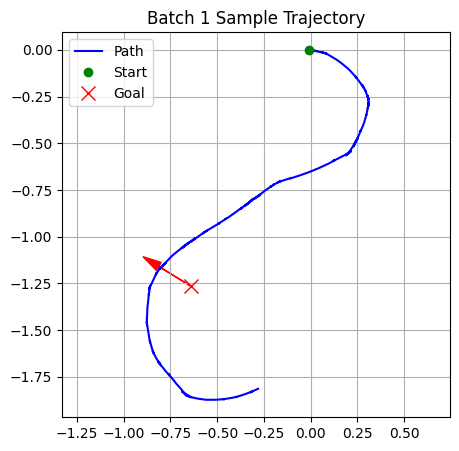

Update | Ep 40 | Avg Reward: 714.6 | Last Reward: -464.4 | Success: False


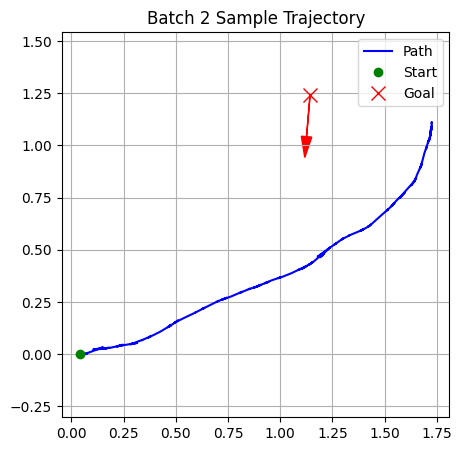

Update | Ep 60 | Avg Reward: 715.4 | Last Reward: 104.1 | Success: False


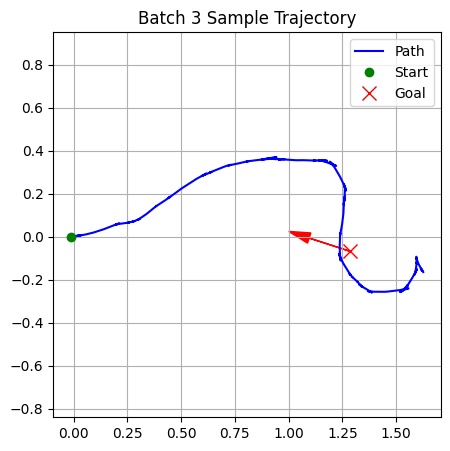

Update | Ep 80 | Avg Reward: 843.9 | Last Reward: 711.9 | Success: False


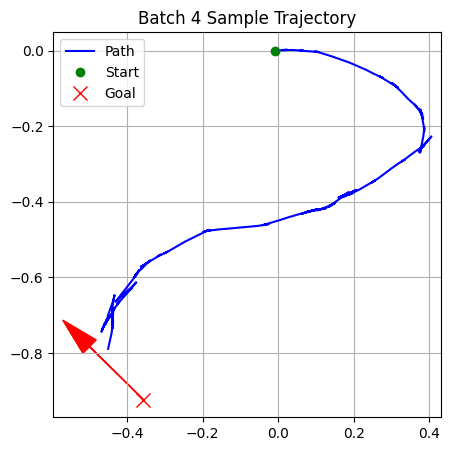

Update | Ep 100 | Avg Reward: 963.5 | Last Reward: 3659.2 | Success: True


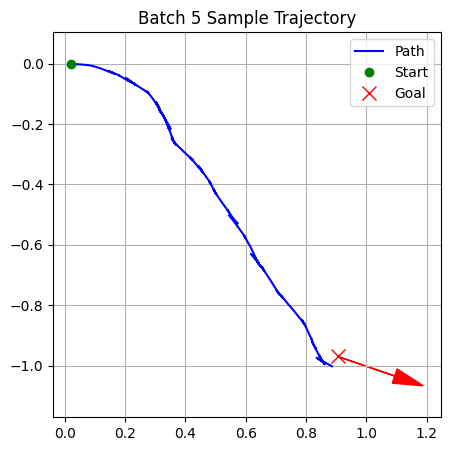

Update | Ep 120 | Avg Reward: 1083.5 | Last Reward: 2104.6 | Success: False


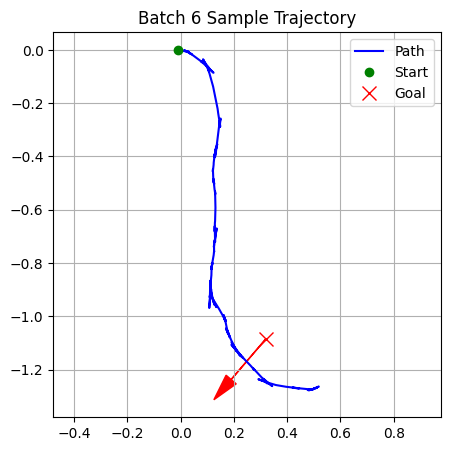

Update | Ep 140 | Avg Reward: 869.8 | Last Reward: 652.9 | Success: False


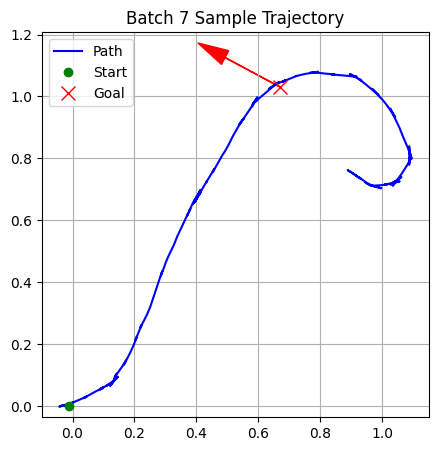

Update | Ep 160 | Avg Reward: 1116.1 | Last Reward: 652.5 | Success: False


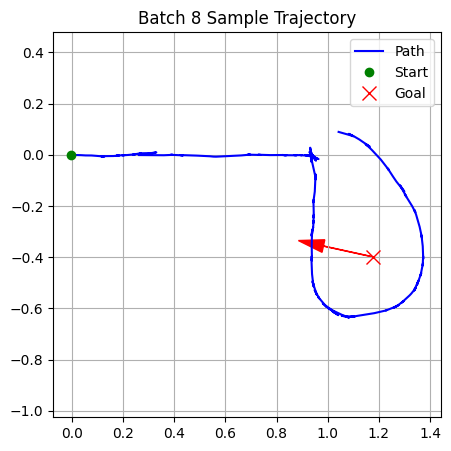

Update | Ep 180 | Avg Reward: 818.3 | Last Reward: 882.3 | Success: False


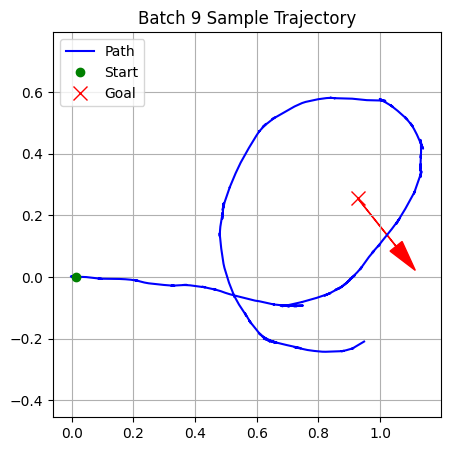

Update | Ep 200 | Avg Reward: 696.7 | Last Reward: 103.3 | Success: False


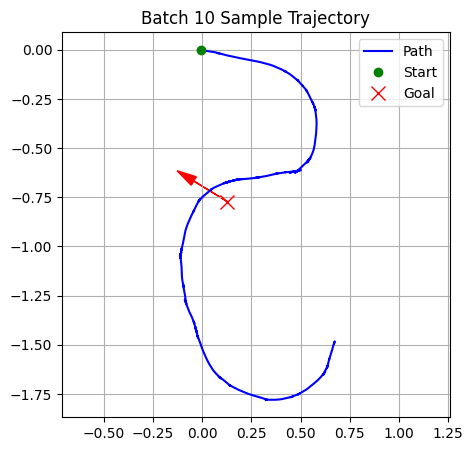

Update | Ep 220 | Avg Reward: 988.8 | Last Reward: 3306.5 | Success: True


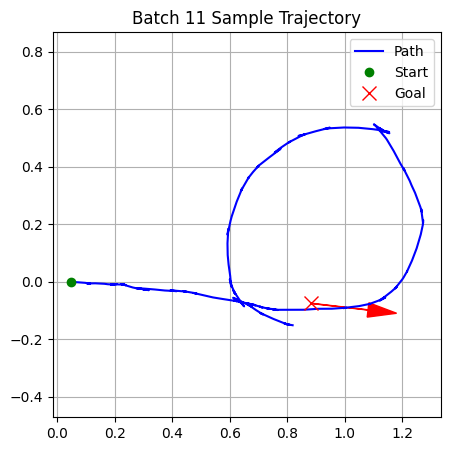

Update | Ep 240 | Avg Reward: 904.6 | Last Reward: 472.1 | Success: False


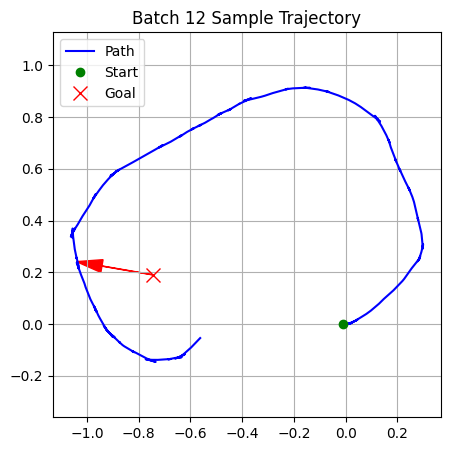

Update | Ep 260 | Avg Reward: 997.4 | Last Reward: 310.1 | Success: False


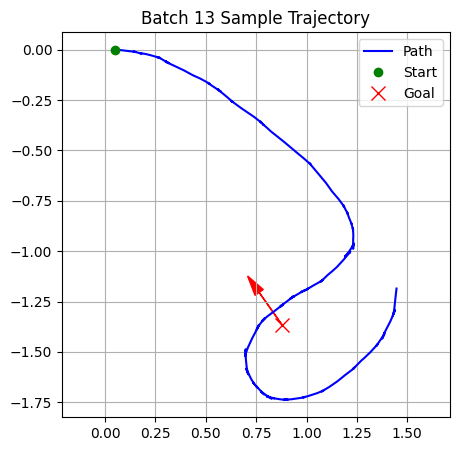

Update | Ep 280 | Avg Reward: 1575.9 | Last Reward: 942.3 | Success: False


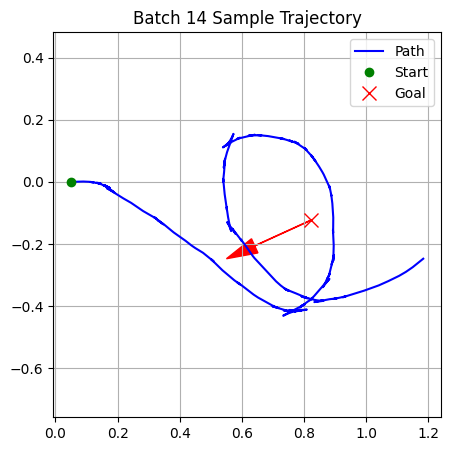

Update | Ep 300 | Avg Reward: 670.8 | Last Reward: 806.9 | Success: False


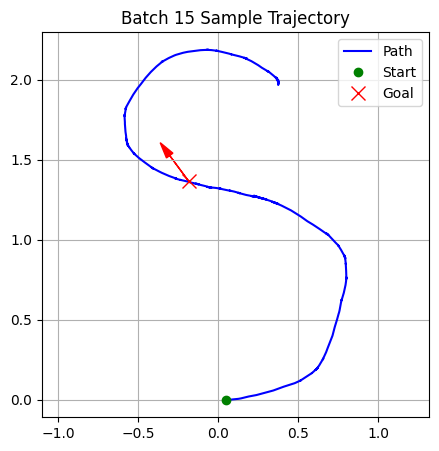

Update | Ep 320 | Avg Reward: 1178.3 | Last Reward: 854.5 | Success: False


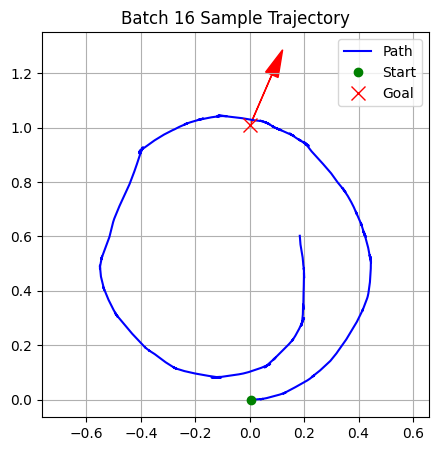

Update | Ep 340 | Avg Reward: 1332.4 | Last Reward: 2594.9 | Success: True


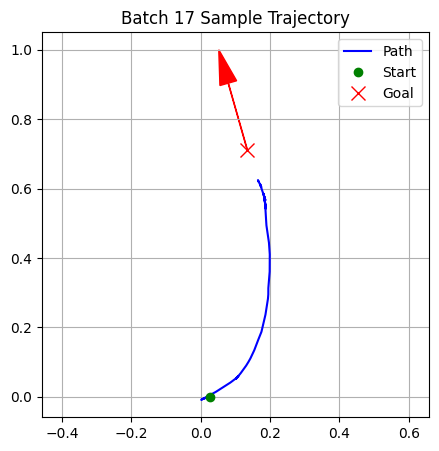

Update | Ep 360 | Avg Reward: 839.0 | Last Reward: 3419.9 | Success: True


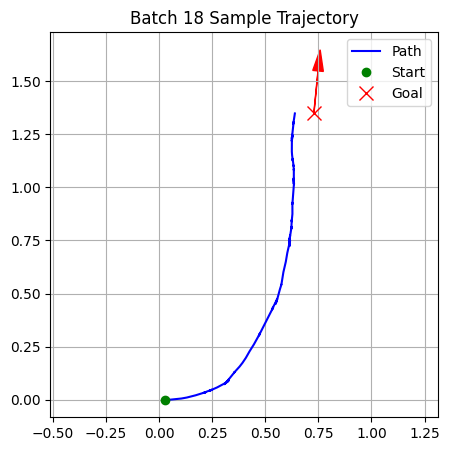

Update | Ep 380 | Avg Reward: 1137.5 | Last Reward: 448.8 | Success: False


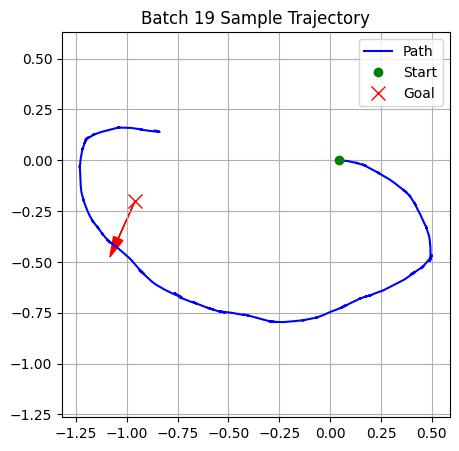

Update | Ep 400 | Avg Reward: 1307.2 | Last Reward: 335.0 | Success: False


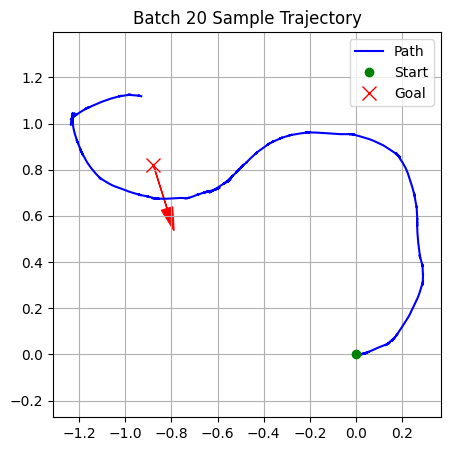

Update | Ep 420 | Avg Reward: 1254.8 | Last Reward: 2092.6 | Success: False


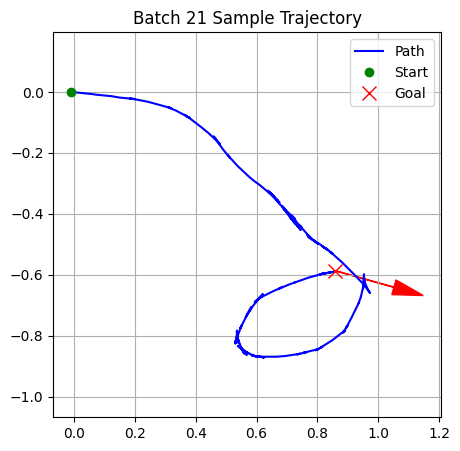

Update | Ep 440 | Avg Reward: 1373.0 | Last Reward: 281.1 | Success: False


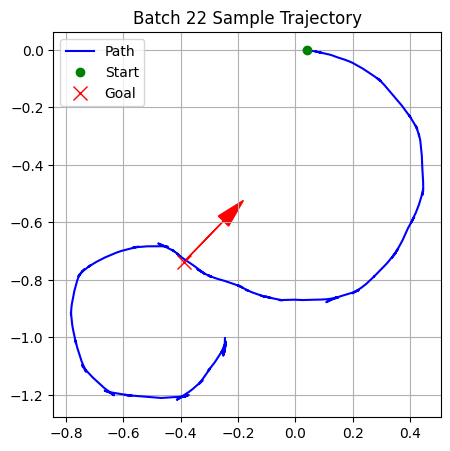

Update | Ep 460 | Avg Reward: 922.5 | Last Reward: 1132.0 | Success: False


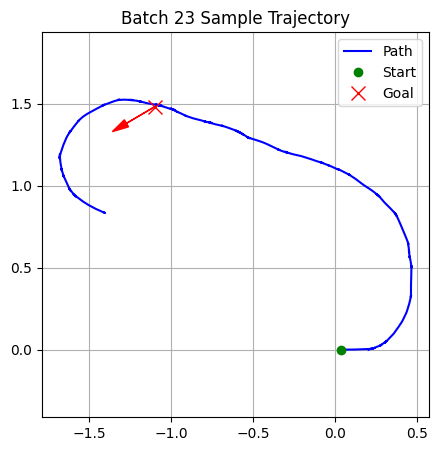

Update | Ep 480 | Avg Reward: 1096.8 | Last Reward: 812.0 | Success: False


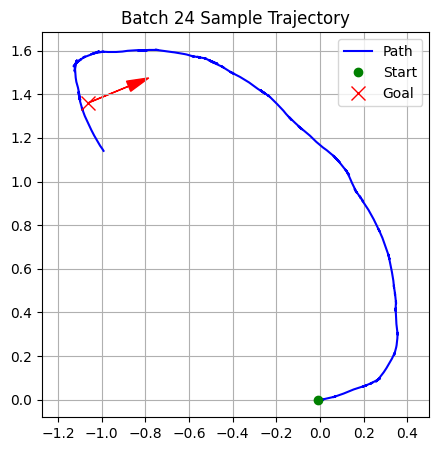

Update | Ep 500 | Avg Reward: 1191.0 | Last Reward: 775.3 | Success: False


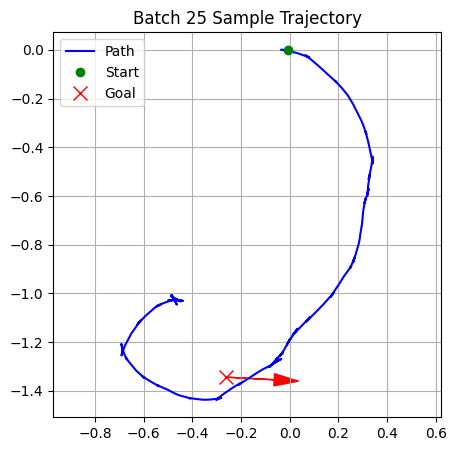

Update | Ep 520 | Avg Reward: 1423.5 | Last Reward: 3793.9 | Success: True


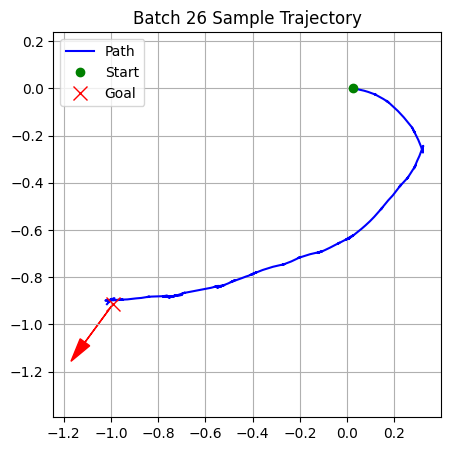

Update | Ep 540 | Avg Reward: 1122.7 | Last Reward: 1459.9 | Success: False


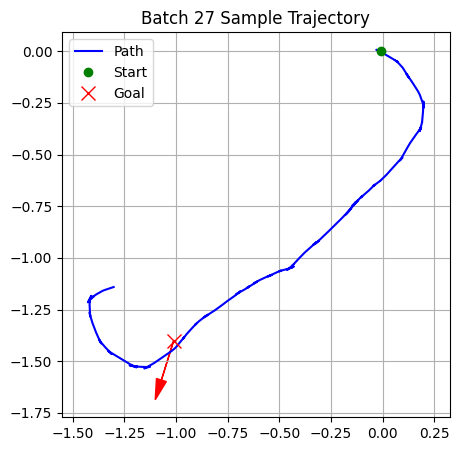

Update | Ep 560 | Avg Reward: 1337.8 | Last Reward: 1434.3 | Success: False


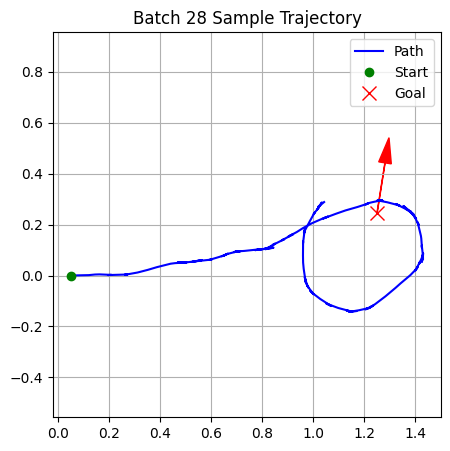

Update | Ep 580 | Avg Reward: 1520.5 | Last Reward: 1706.7 | Success: False


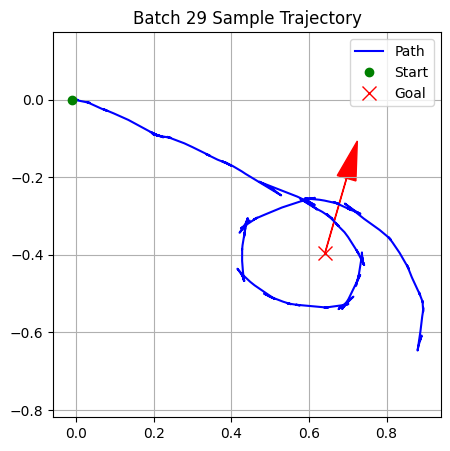

Update | Ep 600 | Avg Reward: 1490.0 | Last Reward: 1425.2 | Success: False


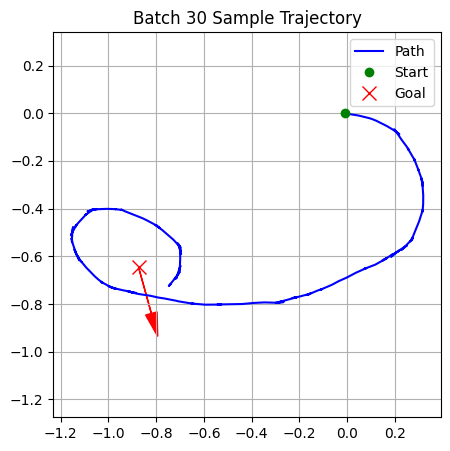

Update | Ep 620 | Avg Reward: 1364.7 | Last Reward: 1225.3 | Success: False


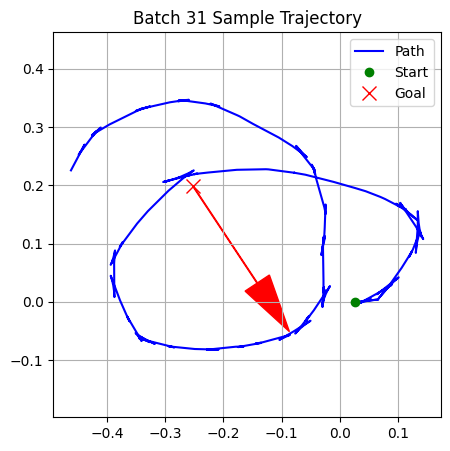

Update | Ep 640 | Avg Reward: 1250.2 | Last Reward: 3744.5 | Success: True


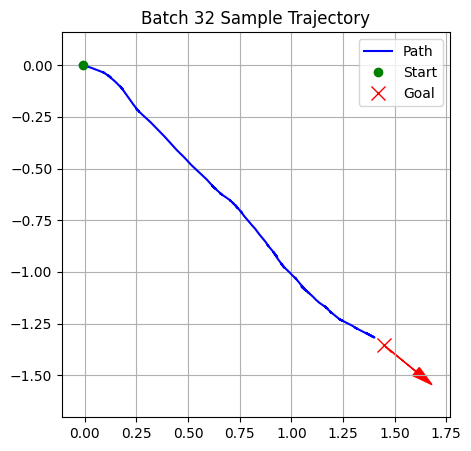

Update | Ep 660 | Avg Reward: 1316.6 | Last Reward: 1118.9 | Success: False


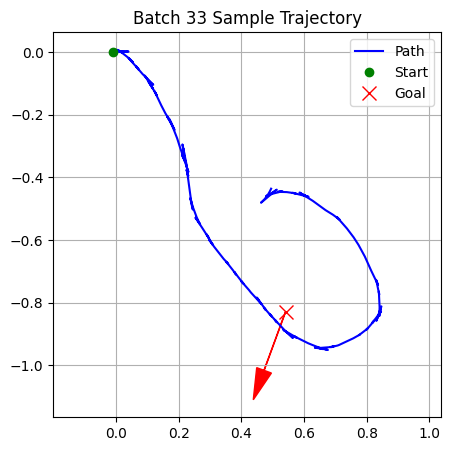

Update | Ep 680 | Avg Reward: 1289.1 | Last Reward: 3288.3 | Success: True


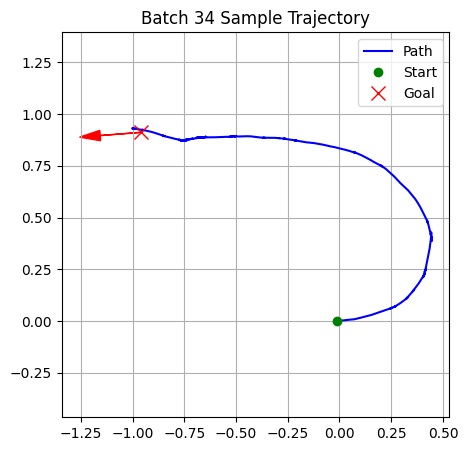

Update | Ep 700 | Avg Reward: 832.9 | Last Reward: 7.7 | Success: False


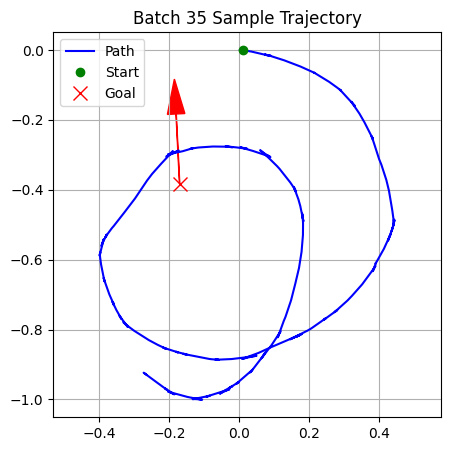

Update | Ep 720 | Avg Reward: 1504.0 | Last Reward: 1555.8 | Success: False


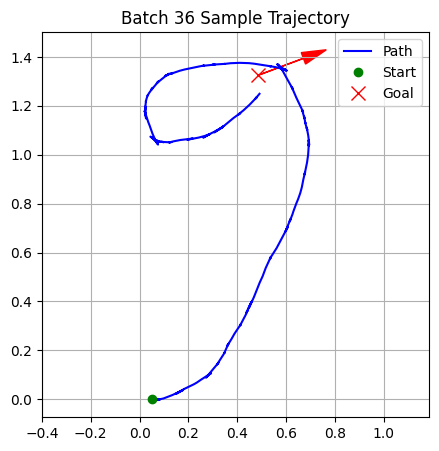

Update | Ep 740 | Avg Reward: 1331.8 | Last Reward: 1323.0 | Success: False


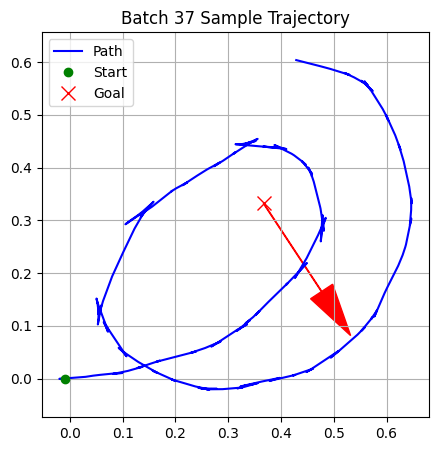

Update | Ep 760 | Avg Reward: 1265.1 | Last Reward: 3113.6 | Success: True


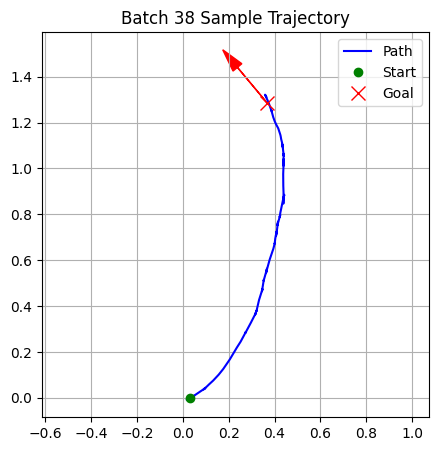

Update | Ep 780 | Avg Reward: 1196.7 | Last Reward: 970.0 | Success: False


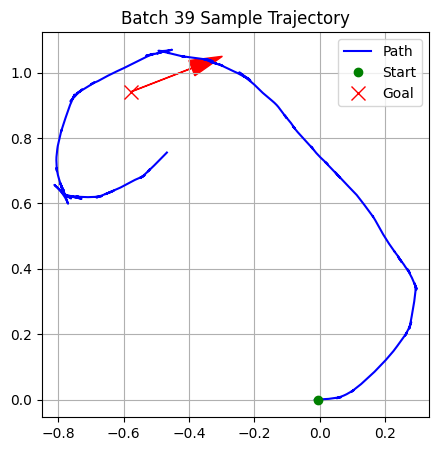

Update | Ep 800 | Avg Reward: 1243.5 | Last Reward: 2076.2 | Success: False


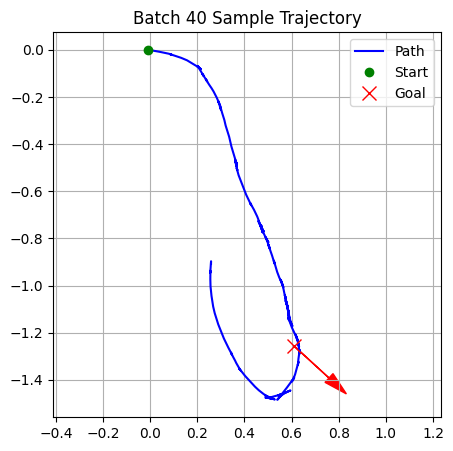

Update | Ep 820 | Avg Reward: 1270.9 | Last Reward: 1194.3 | Success: False


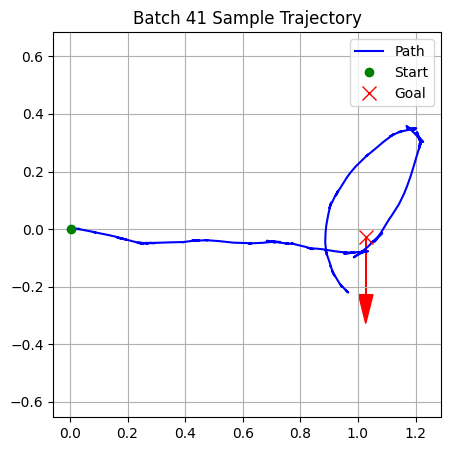

Update | Ep 840 | Avg Reward: 1564.8 | Last Reward: 1222.4 | Success: False


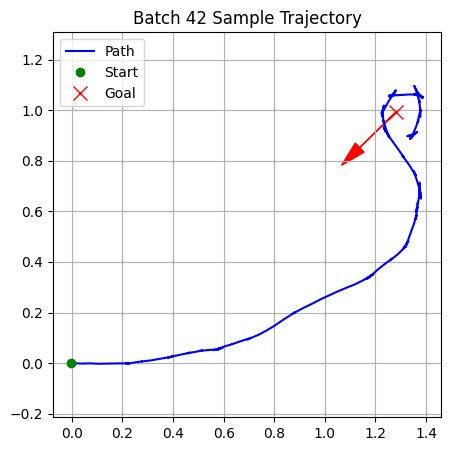

Update | Ep 860 | Avg Reward: 1331.1 | Last Reward: 904.2 | Success: False


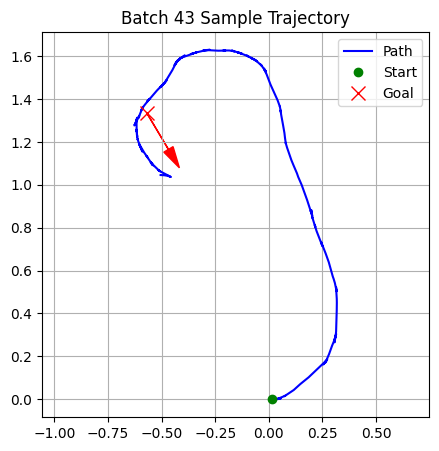

Update | Ep 880 | Avg Reward: 1367.6 | Last Reward: 1277.0 | Success: False


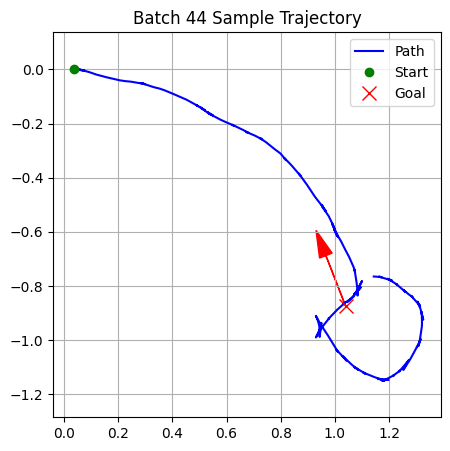

Update | Ep 900 | Avg Reward: 1599.6 | Last Reward: 1452.5 | Success: False


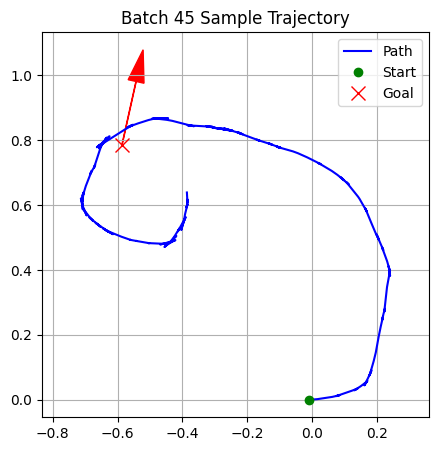

Update | Ep 920 | Avg Reward: 1566.5 | Last Reward: 2012.5 | Success: False


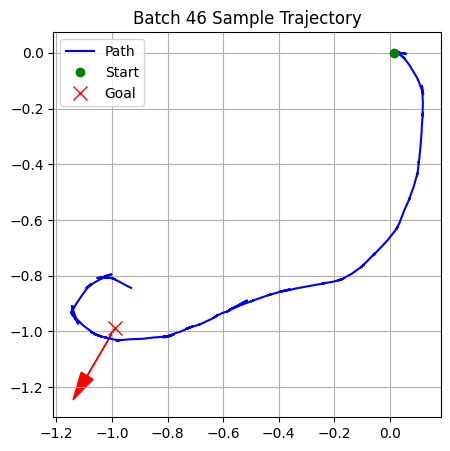

Update | Ep 940 | Avg Reward: 1317.8 | Last Reward: 1139.0 | Success: False


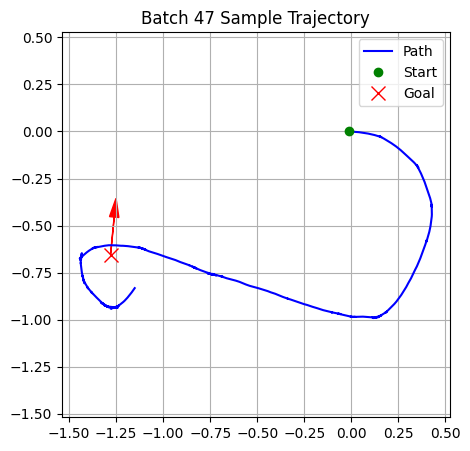

Update | Ep 960 | Avg Reward: 1298.7 | Last Reward: 441.1 | Success: False


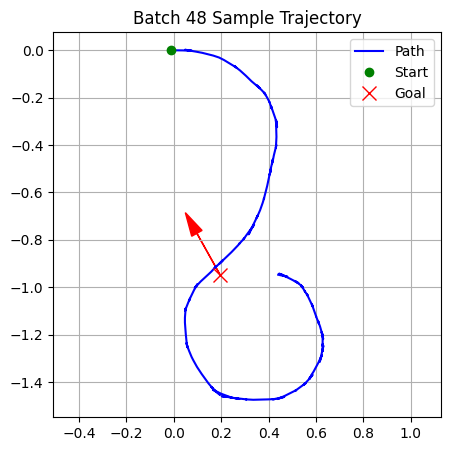

Update | Ep 980 | Avg Reward: 1322.1 | Last Reward: 317.7 | Success: False


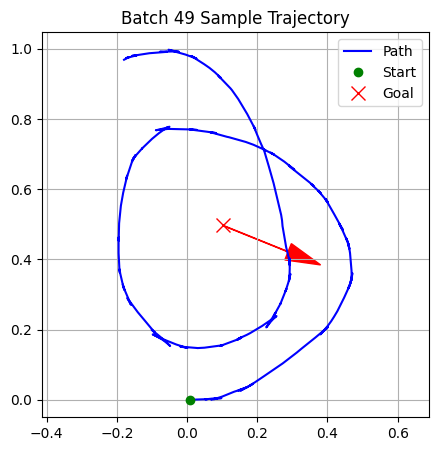

Update | Ep 1000 | Avg Reward: 1271.4 | Last Reward: 1245.6 | Success: False


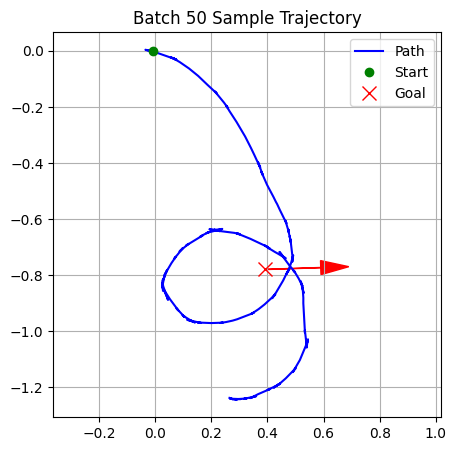

Update | Ep 1020 | Avg Reward: 1462.2 | Last Reward: 78.6 | Success: False


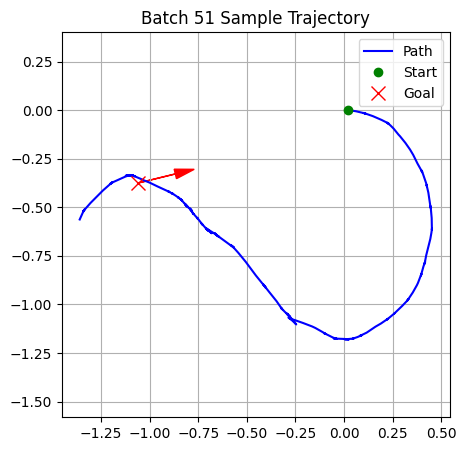

Update | Ep 1040 | Avg Reward: 1791.9 | Last Reward: 3296.9 | Success: True


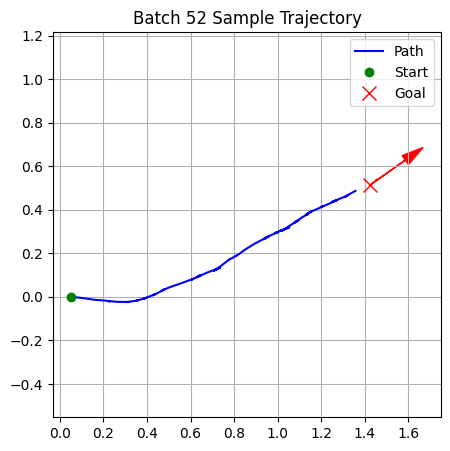

Update | Ep 1060 | Avg Reward: 1300.7 | Last Reward: 705.8 | Success: False


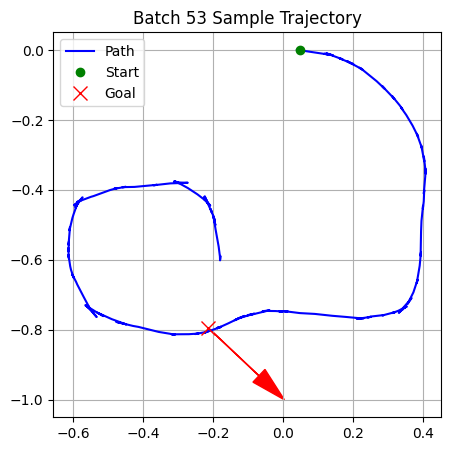

Update | Ep 1080 | Avg Reward: 1360.4 | Last Reward: 2361.5 | Success: True


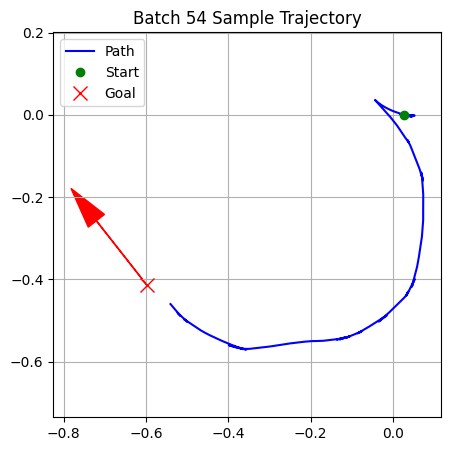

Update | Ep 1100 | Avg Reward: 1008.1 | Last Reward: 839.6 | Success: False


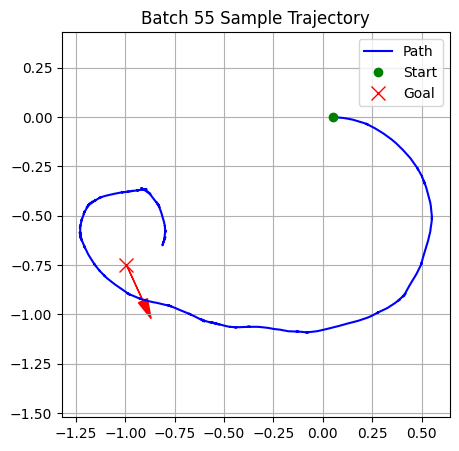

Update | Ep 1120 | Avg Reward: 937.7 | Last Reward: 239.0 | Success: False


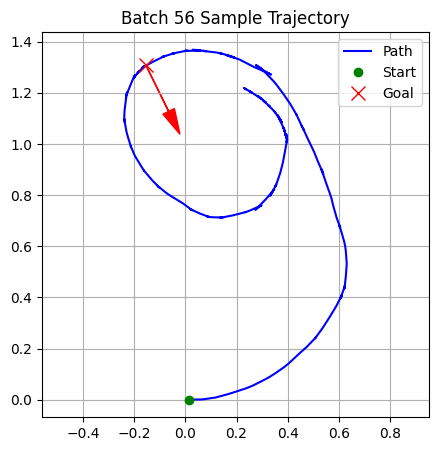

Update | Ep 1140 | Avg Reward: 821.5 | Last Reward: 676.9 | Success: False


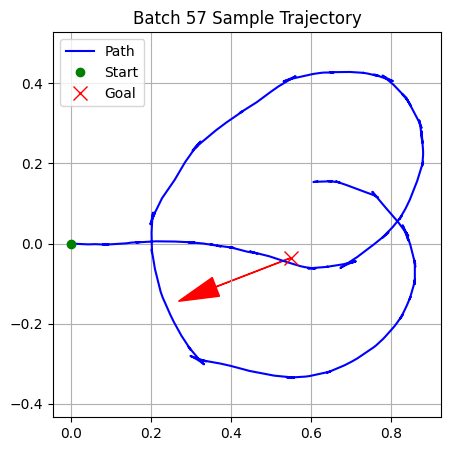

Update | Ep 1160 | Avg Reward: 613.2 | Last Reward: 1016.0 | Success: False


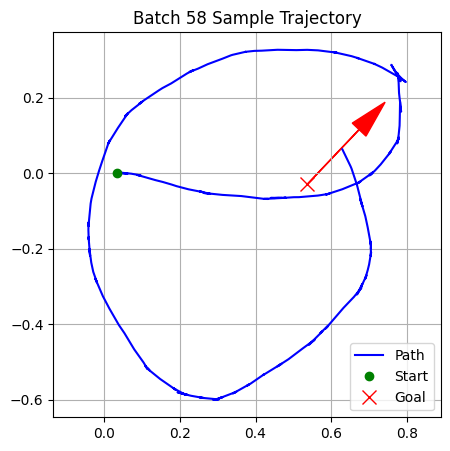

Update | Ep 1180 | Avg Reward: 1218.0 | Last Reward: 1651.9 | Success: False


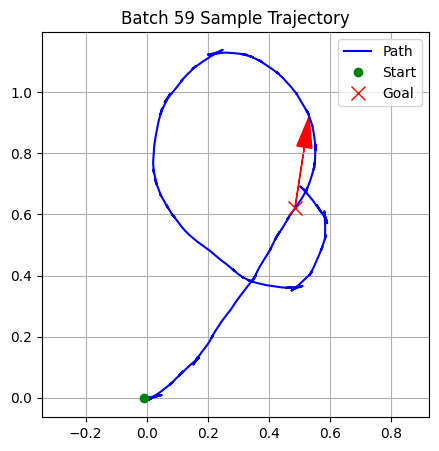

Update | Ep 1200 | Avg Reward: 1070.9 | Last Reward: 1819.5 | Success: False


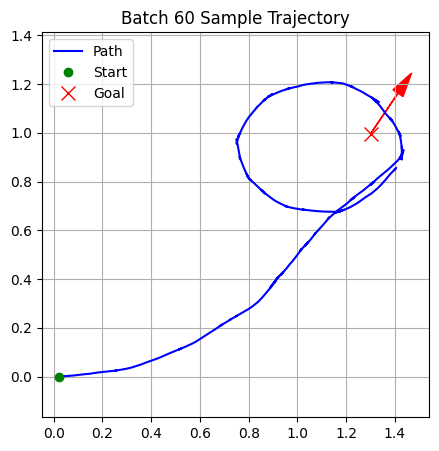

Update | Ep 1220 | Avg Reward: 1121.1 | Last Reward: 1471.5 | Success: False


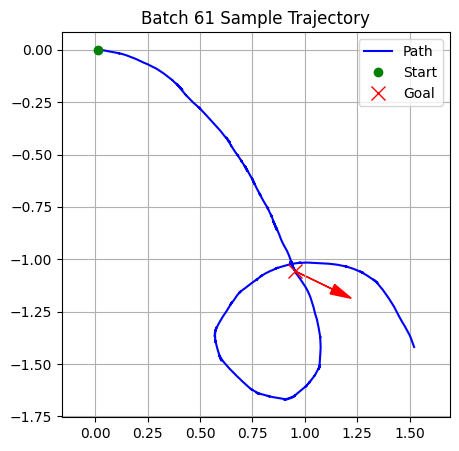

Update | Ep 1240 | Avg Reward: 1984.0 | Last Reward: 2212.8 | Success: False


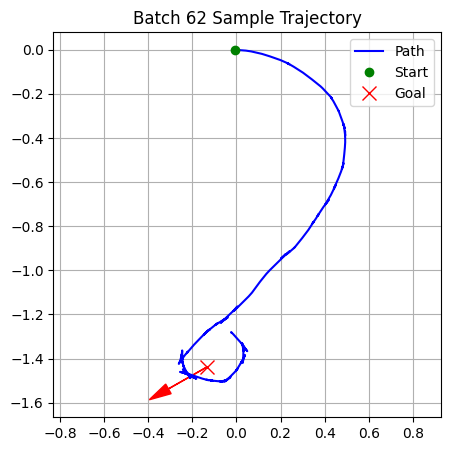

Update | Ep 1260 | Avg Reward: 1717.2 | Last Reward: 1096.0 | Success: False


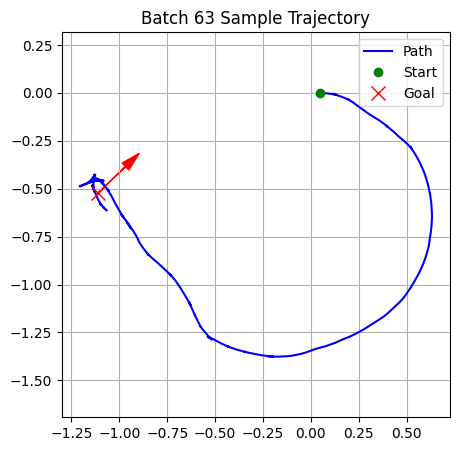

Update | Ep 1280 | Avg Reward: 1213.5 | Last Reward: 383.8 | Success: False


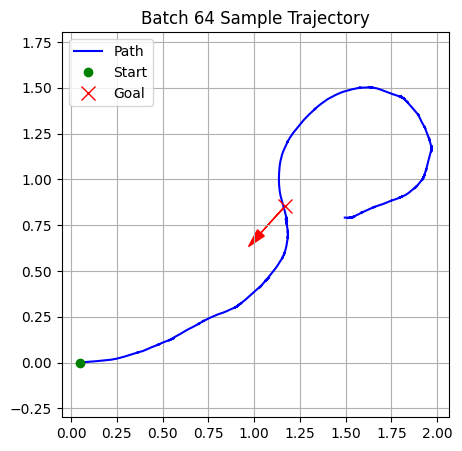

Update | Ep 1300 | Avg Reward: 1750.1 | Last Reward: 737.3 | Success: False


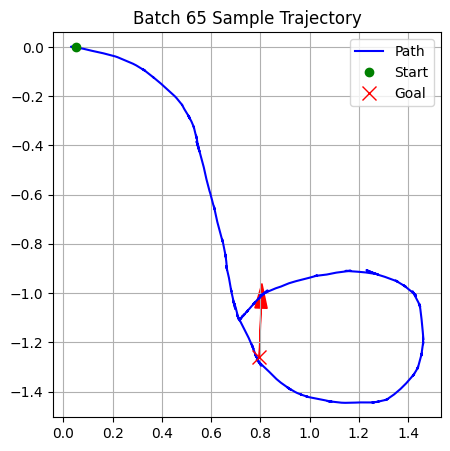

Update | Ep 1320 | Avg Reward: 1342.0 | Last Reward: 1933.9 | Success: False


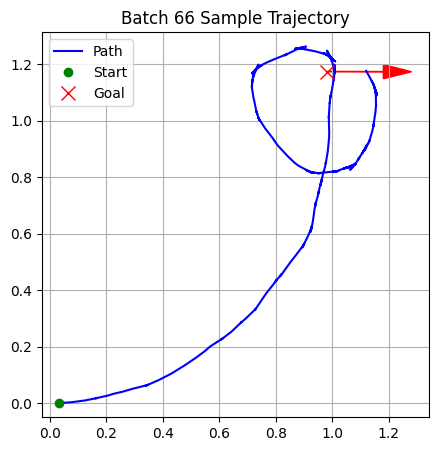

Update | Ep 1340 | Avg Reward: 1401.3 | Last Reward: 2971.3 | Success: True


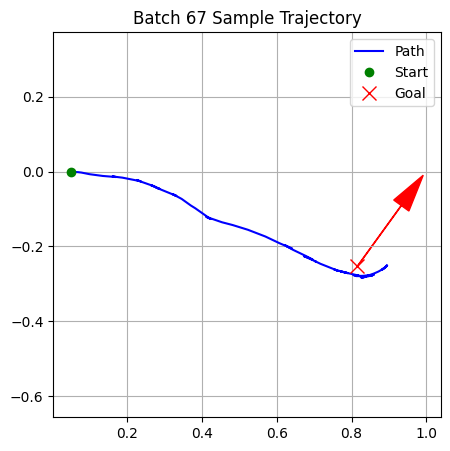

Update | Ep 1360 | Avg Reward: 1327.7 | Last Reward: 196.2 | Success: False


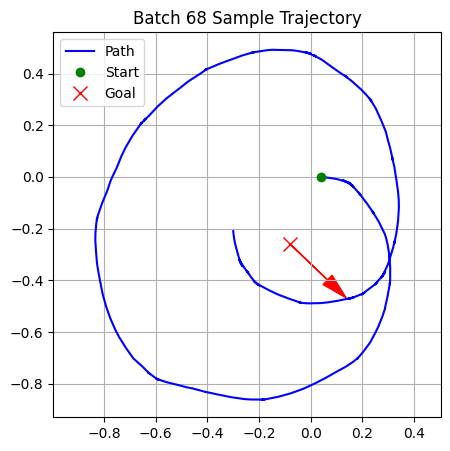

Update | Ep 1380 | Avg Reward: 1260.3 | Last Reward: 370.0 | Success: False


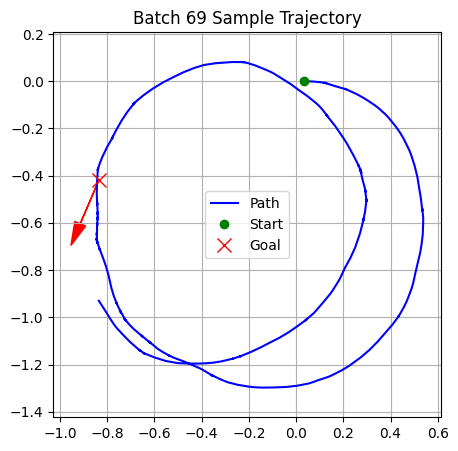

Update | Ep 1400 | Avg Reward: 1382.4 | Last Reward: 582.7 | Success: False


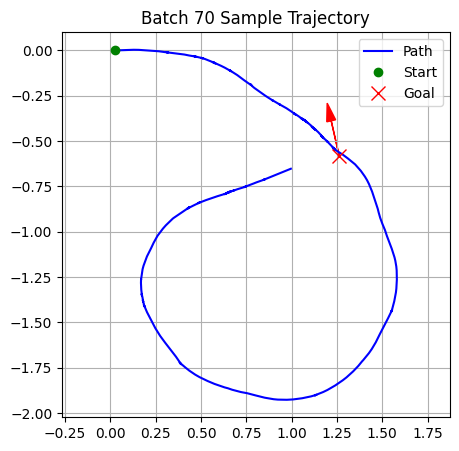

Update | Ep 1420 | Avg Reward: 1995.9 | Last Reward: 977.6 | Success: False


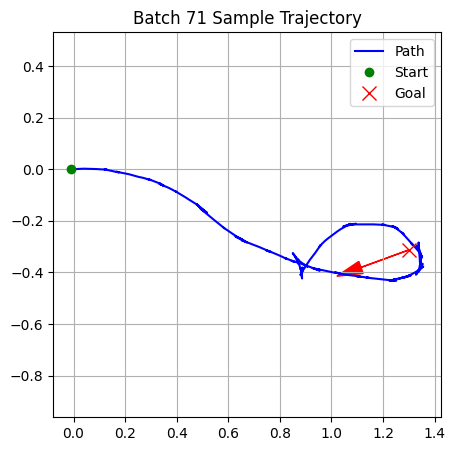

Update | Ep 1440 | Avg Reward: 1033.8 | Last Reward: 2074.1 | Success: False


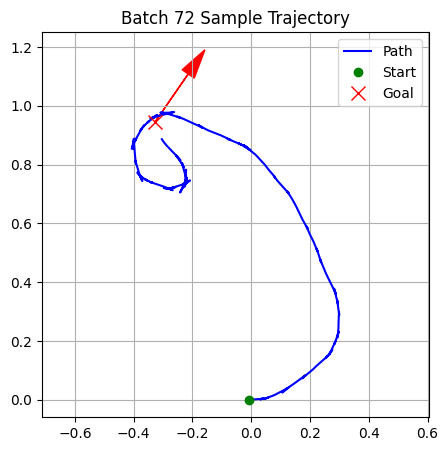

Update | Ep 1460 | Avg Reward: 1351.4 | Last Reward: 316.8 | Success: False


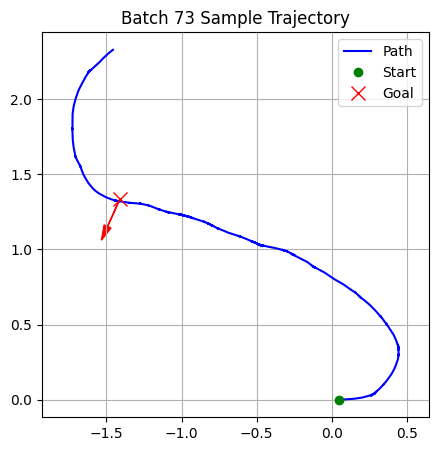

Update | Ep 1480 | Avg Reward: 1009.2 | Last Reward: 417.1 | Success: False


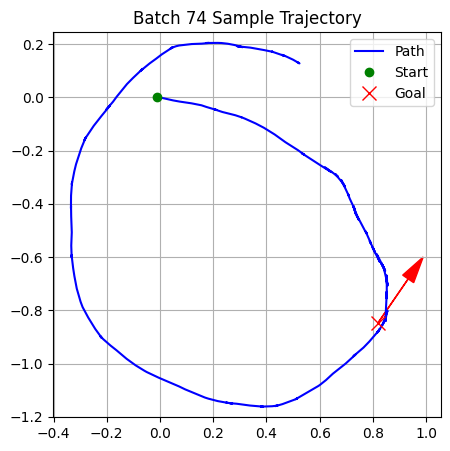

Update | Ep 1500 | Avg Reward: 809.2 | Last Reward: 2272.1 | Success: False


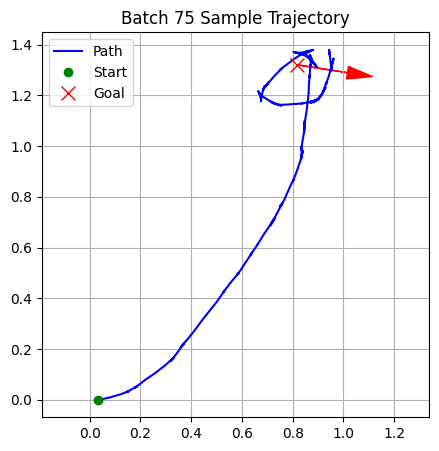

Update | Ep 1520 | Avg Reward: 1559.2 | Last Reward: -49.1 | Success: False


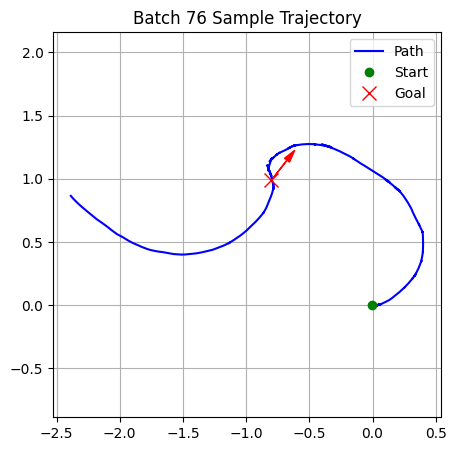

Update | Ep 1540 | Avg Reward: 1050.0 | Last Reward: 1568.5 | Success: False


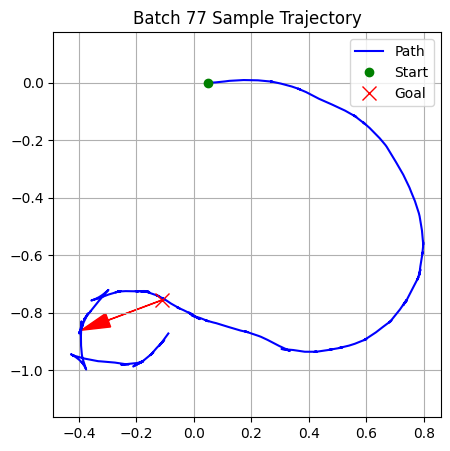

Update | Ep 1560 | Avg Reward: 1419.5 | Last Reward: 48.0 | Success: False


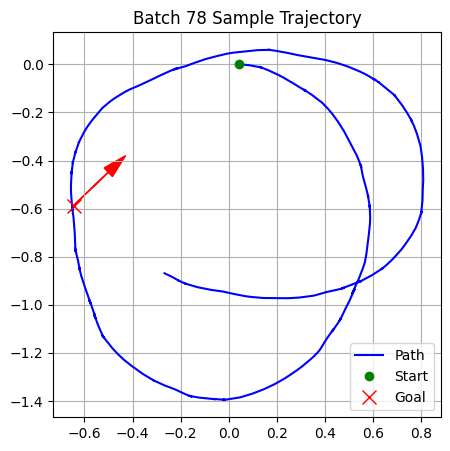

Update | Ep 1580 | Avg Reward: 1573.0 | Last Reward: 3585.9 | Success: True


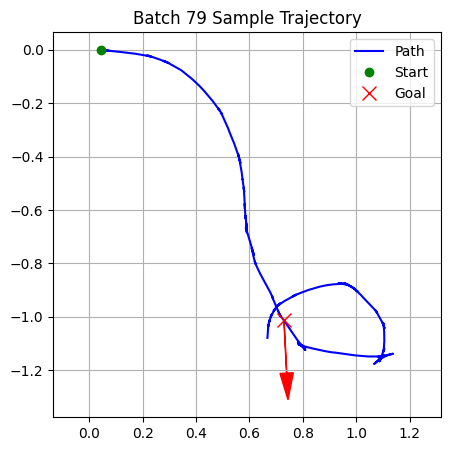

Update | Ep 1600 | Avg Reward: 2071.1 | Last Reward: 1080.6 | Success: False


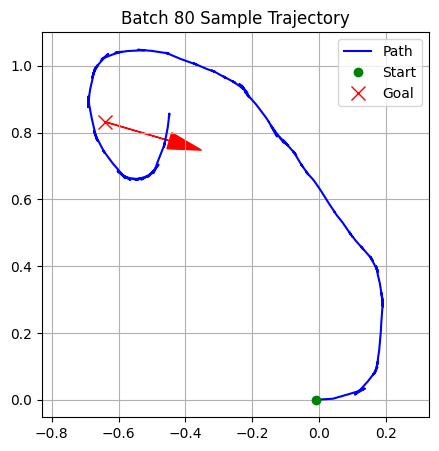

Update | Ep 1620 | Avg Reward: 1595.2 | Last Reward: 1411.1 | Success: False


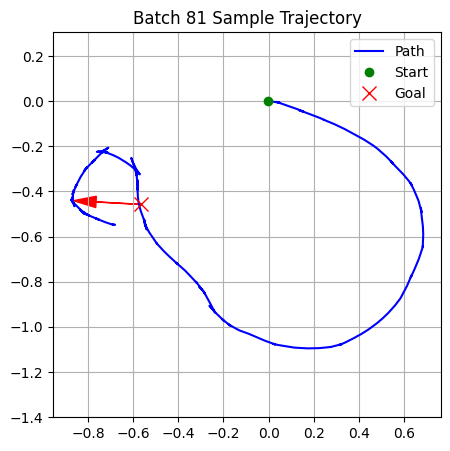

Update | Ep 1640 | Avg Reward: 1221.0 | Last Reward: 1074.4 | Success: False


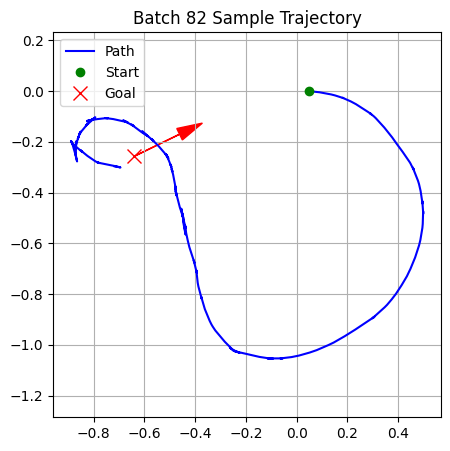

Update | Ep 1660 | Avg Reward: 1998.7 | Last Reward: 1659.8 | Success: False


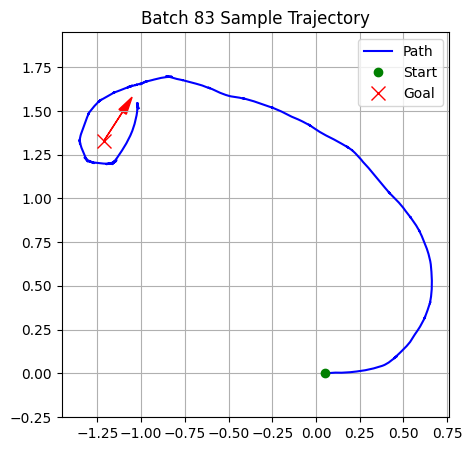

Update | Ep 1680 | Avg Reward: 1752.1 | Last Reward: 2010.8 | Success: False


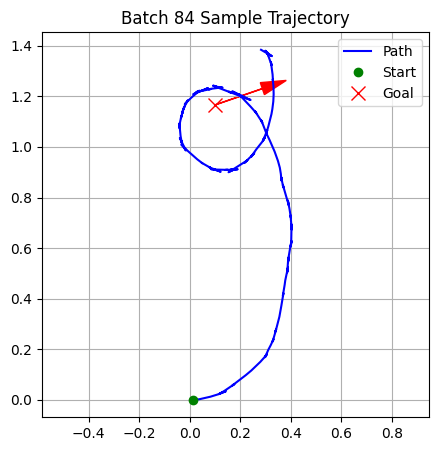

Update | Ep 1700 | Avg Reward: 1392.0 | Last Reward: 2115.0 | Success: False


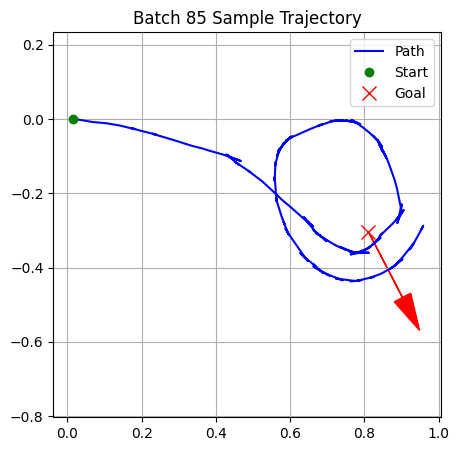

Update | Ep 1720 | Avg Reward: 1619.5 | Last Reward: 1405.8 | Success: False


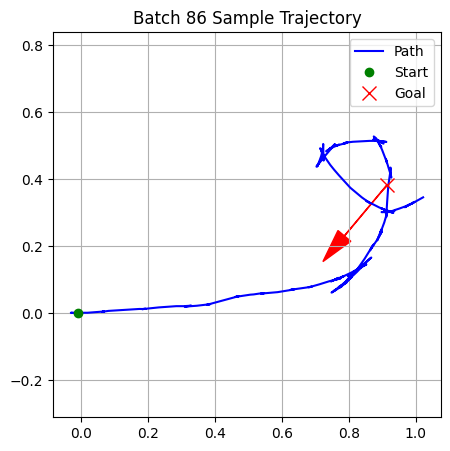

Update | Ep 1740 | Avg Reward: 1942.6 | Last Reward: 1509.0 | Success: False


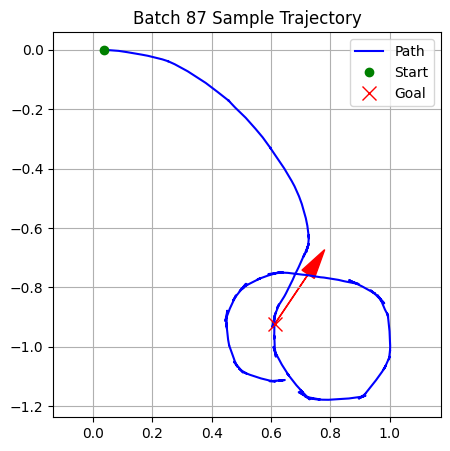

Update | Ep 1760 | Avg Reward: 1914.5 | Last Reward: 520.8 | Success: False


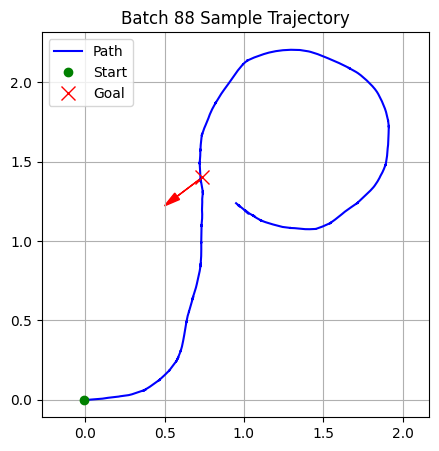

Update | Ep 1780 | Avg Reward: 1683.6 | Last Reward: 2408.5 | Success: False


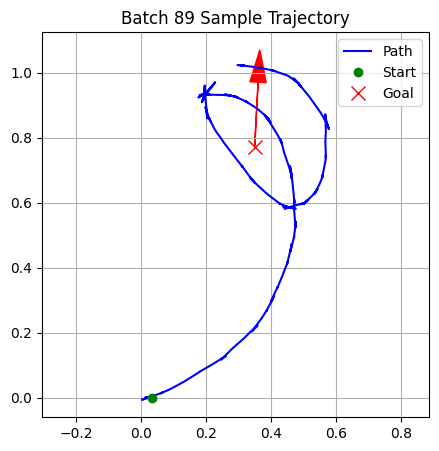

Update | Ep 1800 | Avg Reward: 1954.3 | Last Reward: 2016.2 | Success: False


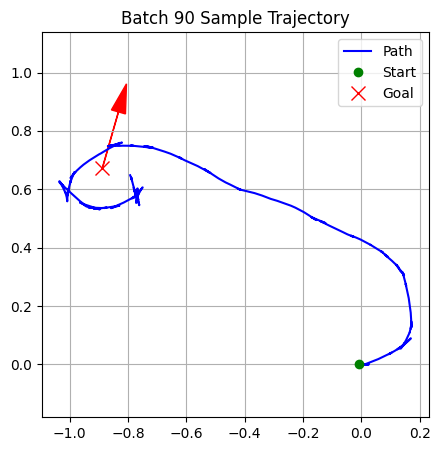

Update | Ep 1820 | Avg Reward: 1757.5 | Last Reward: 249.2 | Success: False


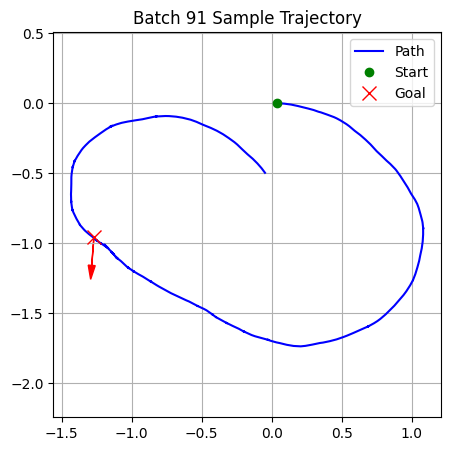

Update | Ep 1840 | Avg Reward: 1694.6 | Last Reward: 1646.7 | Success: False


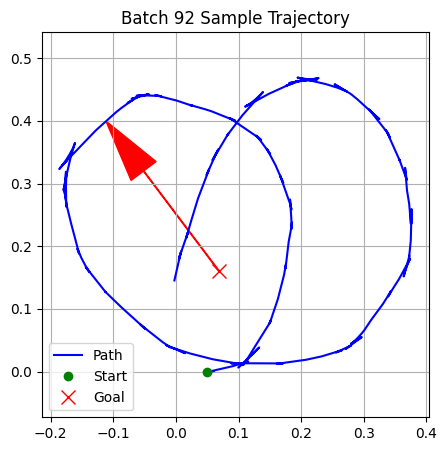

Update | Ep 1860 | Avg Reward: 1764.0 | Last Reward: 2970.0 | Success: True


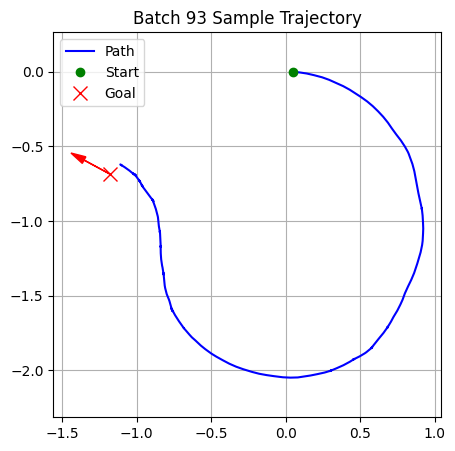

Update | Ep 1880 | Avg Reward: 1934.8 | Last Reward: 1850.6 | Success: False


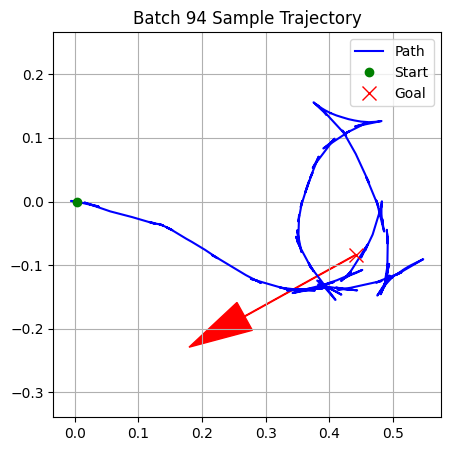

Update | Ep 1900 | Avg Reward: 1850.6 | Last Reward: 2327.7 | Success: True


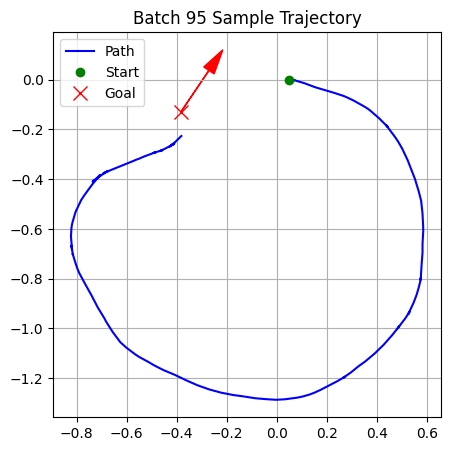

Update | Ep 1920 | Avg Reward: 1873.1 | Last Reward: 2913.8 | Success: True


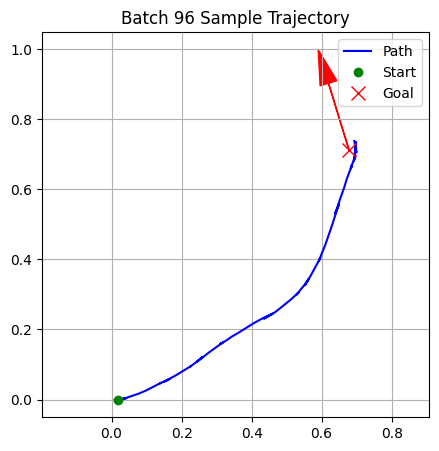

Update | Ep 1940 | Avg Reward: 2197.7 | Last Reward: 1649.2 | Success: False


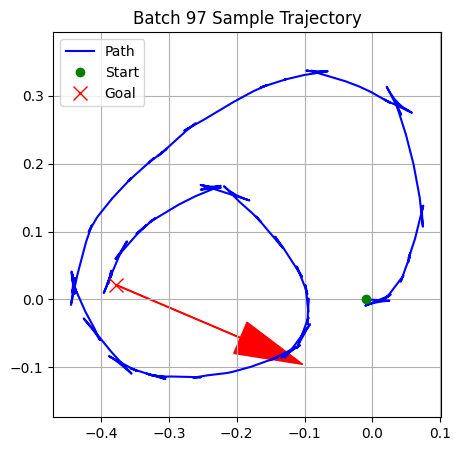

Update | Ep 1960 | Avg Reward: 1542.4 | Last Reward: 903.1 | Success: False


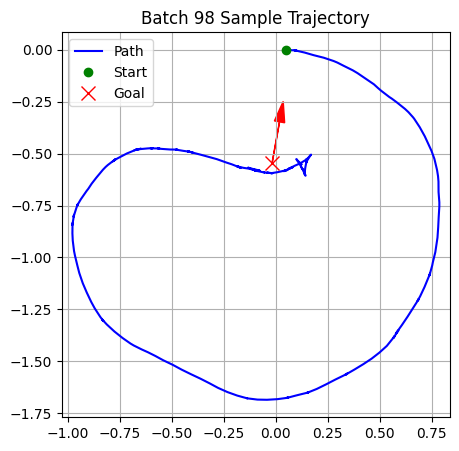

Update | Ep 1980 | Avg Reward: 2056.4 | Last Reward: 2848.9 | Success: True


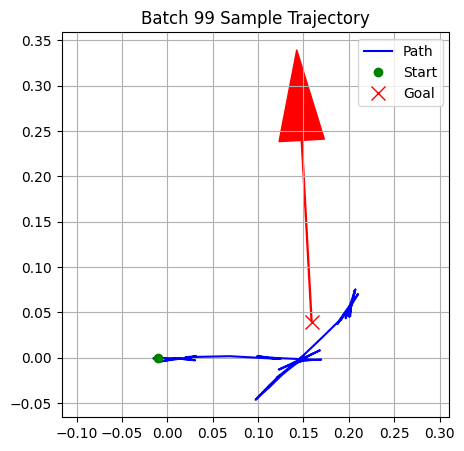

Update | Ep 2000 | Avg Reward: 2293.2 | Last Reward: -82.8 | Success: False


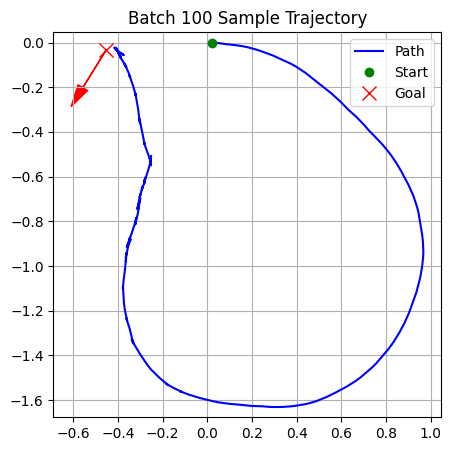

In [9]:
# --- Training Loop Configuration ---
# Use hyperparameters from the MuJoCo benchmark (Table 3) where applicable [cite: 326]
BATCH_SIZE = 20  # Number of episodes before an update
MAX_STEPS = 250  # Horizon T per episode

for episode in range(1, MAX_EPISODES + 1):
    state, _ = env.reset()
    ep_reward = 0
    trajectory = []
    goal_pose = env.goal

    for t in range(MAX_STEPS):
        # 1. Normalize observation (PPO is sensitive to input scaling)
        n_state = obs_normalizer.normalize(state)

        # 2. Get Action, Log Prob, and Value (Value needed for Advantage) [cite: 31, 141]
        action, log_prob, val, _ = agent.get_action(n_state)

        # 3. Step Environment
        next_state, env_reward, terminated, truncated, info = env.step(action)

        # 4. Handle Terminal Flags
        # Collision and Success are handled by NavigationReward, but the paper
        # structures training in fixed-length segments [cite: 138]
        done = terminated or truncated

        # 5. Store in Buffer
        # We store n_state (obs), action, log_prob, reward, and value [cite: 141]
        buffer.store(n_state, action, log_prob, env_reward, val, terminated)

        state = next_state
        ep_reward += env_reward
        trajectory.append(env.state.copy())

        if done:
            break

    reward_history.append(ep_reward)

    # 6. Optimization Update (Algorithm 1)
    # Perform K epochs of SGD on the collected minibatches [cite: 141]
    if episode % BATCH_SIZE == 0:
        update_ppo(agent, optimizer, buffer)  # Uses the logic we defined earlier
        avg_r = np.mean(reward_history[-BATCH_SIZE:])
        print(f"Update | Ep {episode} | Avg Reward: {avg_r:.1f} | Last Reward: {ep_reward:.1f} | Success: {info['is_success']}")
        plot_trajectory(trajectory, goal_pose, episode)

### Cell 7: Visualization & Save
Plot the learning curve to verify convergence.

Results will be saved to: /content/drive/MyDrive/final_assignment/outputs/models_saved/experiments/ppo_nav_20260111_122612


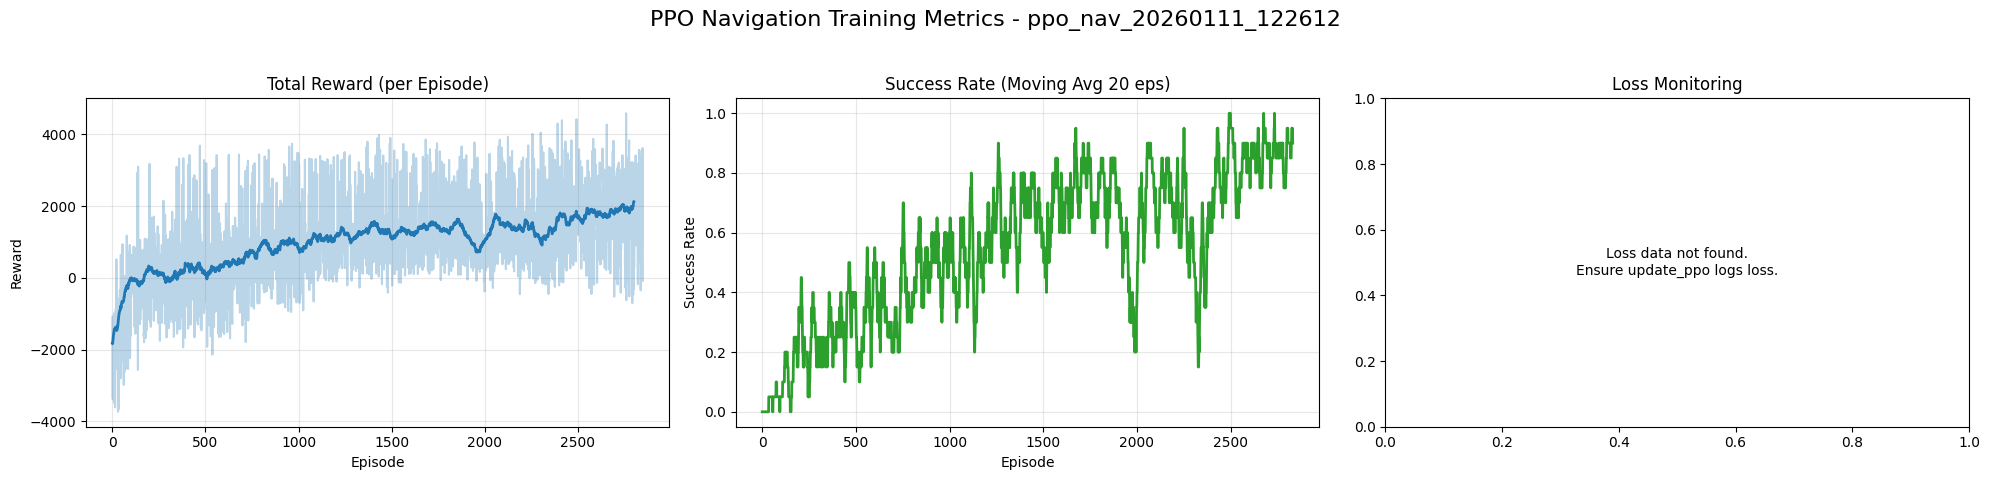

------------------------------
TRAINING SUMMARY SAVED
Final Success Rate (last 20 eps): 90.00%
Model: nav_agent_final.pth
Plots: training_summary.png
------------------------------


In [10]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# --- 1. SETUP DIRECTORY STRUCTURE ---
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_id = f"ppo_nav_{current_time}"

# Use the drive_path defined earlier or local experiments folder
base_output_path = os.path.join(drive_path, "experiments") if 'drive_path' in locals() else "experiments"
output_dir = os.path.join(base_output_path, run_id)
os.makedirs(output_dir, exist_ok=True)

print(f"Results will be saved to: {output_dir}")

# --- 2. PREPARE DATA ---
# Helper to handle potential tensor/numpy mix in histories
def clean_history(history):
    return [h.detach().cpu().item() if torch.is_tensor(h) else h for h in history]

clean_rewards = clean_history(reward_history)
# Note: Ensure your update_ppo function returns these loss components
# For now, we plot reward and a smoothed version of success
success_history = [1 if r > REWARD_GOAL * 0.8 else 0 for r in clean_rewards]
smoothed_success = np.convolve(success_history, np.ones(20)/20, mode='valid')

# --- 3. PLOTTING ---
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Total Reward
axs[0].plot(clean_rewards, color='tab:blue', alpha=0.3)
# Add a rolling average to see the trend through the noise
if len(clean_rewards) > 50:
    rolling_avg = np.convolve(clean_rewards, np.ones(50)/50, mode='valid')
    axs[0].plot(rolling_avg, color='tab:blue', linewidth=2)
axs[0].set_title("Total Reward (per Episode)")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")
axs[0].grid(True, alpha=0.3)

# Plot 2: Success Rate (Moving Average)
axs[1].plot(smoothed_success, color='tab:green', linewidth=2)
axs[1].set_title("Success Rate (Moving Avg 20 eps)")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Success Rate")
axs[1].set_ylim([-0.05, 1.05])
axs[1].grid(True, alpha=0.3)

# Plot 3: Loss Components (Placeholder for PPO metrics)
# If you track policy_loss and value_loss in your update function, plot them here
if 'loss_history' in locals() and len(loss_history) > 0:
    axs[2].plot(clean_history(loss_history), color='tab:red')
    axs[2].set_title("Total PPO Loss")
    axs[2].set_xlabel("Batch Update")
    axs[2].grid(True, alpha=0.3)
else:
    axs[2].text(0.5, 0.5, "Loss data not found.\nEnsure update_ppo logs loss.",
                ha='center', va='center')
    axs[2].set_title("Loss Monitoring")

plt.suptitle(f"PPO Navigation Training Metrics - {run_id}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot
plot_filename = "training_summary.png"
plt.savefig(os.path.join(output_dir, plot_filename))
plt.show()

# --- 4. SAVING MODEL AND DATA ---
# Save the complete agent (Actor + Critic)
model_filename = "nav_agent_final.pth"
torch.save(agent.state_dict(), os.path.join(output_dir, model_filename))

# Save histories for post-training comparison
np.save(os.path.join(output_dir, "reward_history.npy"), np.array(clean_rewards))
np.save(os.path.join(output_dir, "success_history.npy"), np.array(success_history))

print("-" * 30)
print(f"TRAINING SUMMARY SAVED")
print(f"Final Success Rate (last 20 eps): {np.mean(success_history[-20:]):.2%}")
print(f"Model: {model_filename}")
print(f"Plots: {plot_filename}")
print("-" * 30)

### Cell 8: ⚠ Delete the train directory ( only for bed results )

In [ ]:
import shutil

# --- DELETE CURRENT EXPERIMENT DIRECTORY ---
# Ask for confirmation to prevent accidental deletion
confirm = input(f"Do you want to delete the directory '{run_id}'? (y/n): ")

if confirm.lower() == 'y':
    try:
        # shutil.rmtree deletes a directory and all its contents
        shutil.rmtree(output_dir)
        print(f"Successfully deleted: {output_dir}")
    except OSError as e:
        print(f"Error: {e.strerror}. Could not delete the directory.")
else:
    print("Deletion cancelled. Experiment results preserved.")